In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import minimize_scalar 
import matplotlib.pyplot as plt

### Monte carlo

In [3]:
def monte_carlo_estimate(probe, t, w = lambda x: 1):
    p = sum((1 * w(x) for x in probe if x >= t))/len(probe)
    return p

### Simulation gain 

for known distribution 


In [4]:
# setting
left_margin = 0.01
right_margin = 10
density = 100

def simulation_gain_known(g: callable, W: callable, G: float, pdf_STD: callable, pdf_IS: callable, left_lim_STD, right_lim_STD, left_lim_IS, right_lim_IS) -> (float, float):
    '''Here G must be numer (exact evaluation from known distributions)'''
    # calculating expected values
    e_g2_STD, err_1 = quad(lambda x: g(x)**2 * pdf_STD(x), left_lim_STD, right_lim_STD)
    e_g2_IS, err_2 = quad(lambda x: g(x)*2 * W(x)**2 * pdf_IS(x), left_lim_IS, right_lim_IS)
    # calculating return values
    rtn_val = (e_g2_STD - G**2) / (e_g2_IS - G**2)
    rtn_err = max(err_1, err_2)
    return rtn_val, rtn_err
    
def simulation_gain_tail_kd(p_t: float, t: float, W: callable, pdf_IS, left_lim, right_lim) -> float:
    left_lim = max(t, left_lim)
    # problem with integrating 
    mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
    rtn_val = (p_t * (1 - p_t)) / (mean - p_t**2)
    return abs(rtn_val), rtn_err
    # tutaj jest błąd to p_t też trzeba liczyć tylko wydaje mi się to całkami było by najlepiej zrobić (to jest wartośc oczekiwana że X osiągnie tę wartośc czyli po prostu całka na po gęstości)
    # to wszystko trzeba w całkach zrobić (do góry też, i błąd z tych całek ściągnąć i zrobi√ widełki z dokładnością)


### Functions for estimation of probabilities  

derivation:

$$\hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*$$

In [ ]:
def p_estim(t: float, sample: tuple, W: callable) -> float:
    '''
    We need provide sample from $f_*$ or rearange function W which is given

    We estimate parameter $p$:
    .. math::
        \hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*

    '''
    return sum((((x >= t and 1) or 0) * W(x) for x in sample))/len(sample)

def var_estim(t: float, sample: tuple, W: callable) -> float:
    return sum((((x >= t and 1) or 0) * W(x)**2 for x in sample))/len(sample)

def opt_density(p_t, t, pdf):
    return lambda x: ((x >= t and 1) or 0) * pdf(x) / p_t

<>:2: SyntaxWarning: invalid escape sequence '\h'
<>:2: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_15766/173818783.py:2: SyntaxWarning: invalid escape sequence '\h'
  '''


In [7]:
def fact_W_scaling(a: float, f: callable):
    '''creating W functions for IS scaling method'''
    return lambda x ,a=a: a * f(x) / f(x/a)


In [8]:
# density function 
def fact_W_translation(c: float, f: callable) -> callable:
    '''Return W function of translation method of importance sampling'''
    return lambda x, c=c: f(x)/f(x-c)


## Estimating probability 

### Weibull distribution

#### scaling

example from book to for checking functions (we can add this to test)

In [29]:
# deterministic functions implemented from book
def p_true_gen(b, mu):
    return lambda t: np.exp(-(t/mu)**b)

def t_from_p(p, b, mu):
    return (- np.log(p))**(1/b) * mu

def w_gen(a, b, mu):
    return lambda x: a**b * np.exp(-(1-a**-b)*(x/mu)**b)

# problem is to estimate parameter a ~ scaling factor 

def opt_a(t, mu, b):
    a_e = 1/2 * (1 + (t/mu)**b + np.sqrt(1 + (t/mu)**(2*b)))
    return a_e**(1/b)
# tested 

# starting parameters
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)

#args
x_s = np.linspace(left_margin, right_margin, density)
p_t_list = np.array([10**(-i) for i in x_s])
t_list = [t_from_p(p_t, b, mu) for p_t in p_t_list]
a_list = [opt_a(t, mu, b) for t in t_list]
W_list = [w_gen(a, b, mu) for a in a_list]
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, 0, np.inf) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y_s = [val for val, err in val_err]
error = max((err for val, err in val_err))
print(error)



1.3184452331208725e-08


#### transition 

In [30]:
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)

# creating args
x_t = list(np.linspace(left_margin, right_margin, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x_t]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# important, we need to have bound till t because when we have bounds beyond we will get null values at begginigs and we always want to have density on it
c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 15)[0], bounds=[0, t]).x for t in t_list]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t + 15) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y_t = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)




1.4465513168183254e-08


### rozkład normalny 

#### scaling

In [48]:
dist = stats.norm(loc=0, scale=1)

# creating args
x_s = list(np.linspace(left_margin, right_margin, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x_s]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# finding optimal values for a IMPO
a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
# finding functions W
W_list = [fact_W_scaling(a, lambda x: dist.pdf(x)) for a in a_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t+30) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y_s = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)



/tmp/ipykernel_127335/4231547289.py:11: RuntimeWarning: invalid value encountered in scalar divide
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
/tmp/ipykernel_127335/4231547289.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]
/tmp/ipykernel_127335/4231547289.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  a_list = [minimize_scalar(lambda a: quad(lambda x: a * dist.pdf(x)**2/dist.pdf(x/a), t, t + 35)[0], bounds=[0, 10**3]).x for t in t_list]


1.3930225623412691e-08


#### translation

In [49]:
dist = stats.norm(loc=0, scale=1)

# creating args
x_t = list(np.linspace(left_margin, right_margin, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x_t]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)]) 
# finding optimal values for a IMPO
c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, c + 30) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y_t = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)




/tmp/ipykernel_127335/2320236437.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
/tmp/ipykernel_127335/2320236437.py:11: RuntimeWarning: overflow encountered in scalar divide
  c_list = [minimize_scalar(lambda c: quad(lambda x: dist.pdf(x)**2/dist.pdf(x - c), t, t + 35)[0], bounds=[0, 100]).x for t in t_list]
/tmp/ipykernel_127335/2320236437.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  c_list = [minimize_scalar(lambda c:

nan


example of calculating, they show it for normal distribution, (for every distribution we obtain something different how to generlize that problem)

### Testy 
UWAGA: trzeba wywołac wszystie metody z danego rozkładu 

#### testy dotyczące błędu

In [603]:
# testing amount of samples
n_start = 5
n_stop = 100
tries = 3
x_pt_list = []
MC_error, MC_s_error, MC_t_error = [], [], []
MC_error_var, MC_s_error_var, MC_t_error_var = [], [], []
# creating loop which checks error for every item in list
for i in range(n_start, n_stop):
    t, a ,c, p = t_list[i], a_list[i], c_list[i], p_t_list[i]
    x_pt_list.append(p)
    # loop which is for calculating mean error 
    tries_MC, tries_MC_S, tries_MC_t = [], [], []
    for _ in range(tries):
        # probes
        probe_MC = dist.rvs(30)
        probe_IS_translation = dist.rvs(30) + c
        probe_IS_scalling = dist.rvs(30) * a 
        # appending values
        tries_MC.append(abs(monte_carlo_estimate(probe_MC, t) - p)/p)
        tries_MC_S.append(abs(monte_carlo_estimate(probe_IS_translation, t, lambda x: dist.pdf(x)/dist.pdf(x - c)) - p)/p)
        tries_MC_t.append(abs(monte_carlo_estimate(probe_IS_scalling, t, lambda x: a * dist.pdf(x)/dist.pdf(x/a)) - p)/p)
    MC_error.append(np.mean(tries_MC))
    MC_error_var.append(np.var(tries_MC))
    MC_s_error.append(np.mean(tries_MC_S))
    MC_s_error_var.append(np.var(tries_MC_S))
    MC_t_error.append(np.mean(tries_MC_t))
    MC_t_error_var.append(np.var(tries_MC_t))

In [50]:
# testing amount of samples
n_start = 5
n_stop = 100
tries = 3
x_pt_list = []
MC_error, MC_s_error, MC_t_error = [], [], []
MC_error_var, MC_s_error_var, MC_t_error_var = [], [], []

# creating loop which checks error for every item in list
for i in range(n_start, n_stop):
    t, a, c, p = t_list[i], a_list[i], c_list[i], p_t_list[i]
    x_pt_list.append(p)
    
    # loop which is for calculating mean error 
    tries_MC, tries_MC_S, tries_MC_t = [], [], []
    for _ in range(tries):
        # probes
        probe_MC = dist.rvs(30)
        probe_IS_translation = dist.rvs(30) + c
        probe_IS_scaling = dist.rvs(30) * a 
        
        # appending values
        tries_MC.append(abs(monte_carlo_estimate(probe_MC, t) - p) / abs(p))  # Błąd względny dla MC
        tries_MC_S.append(abs(monte_carlo_estimate(probe_IS_translation, t, lambda x: dist.pdf(x) / dist.pdf(x - c)) - p) / abs(p))  # Błąd względny dla IS translacji
        tries_MC_t.append(abs(monte_carlo_estimate(probe_IS_scaling, t, lambda x: a * dist.pdf(x) / dist.pdf(x / a)) - p) / abs(p))  # Błąd względny dla IS skalowania
    
    MC_error.append(np.mean(tries_MC))
    MC_error_var.append(np.var(tries_MC))
    MC_s_error.append(np.mean(tries_MC_S))
    MC_s_error_var.append(np.var(tries_MC_S))
    MC_t_error.append(np.mean(tries_MC_t))
    MC_t_error_var.append(np.var(tries_MC_t))

In [555]:
MC_error.reverse()
MC_s_error.reverse()
MC_t_error.reverse()

In [556]:
p_t_list.reverse()

In [613]:
MC_error[94], MC_s_error[94], MC_t_error[94]

(np.float64(1.0),
 np.float64(0.3704530940177356),
 np.float64(0.5072012824737612))

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_127335/4279826785.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\left|\\frac{\hat{p} - p_t}{p_t}\\right|$')


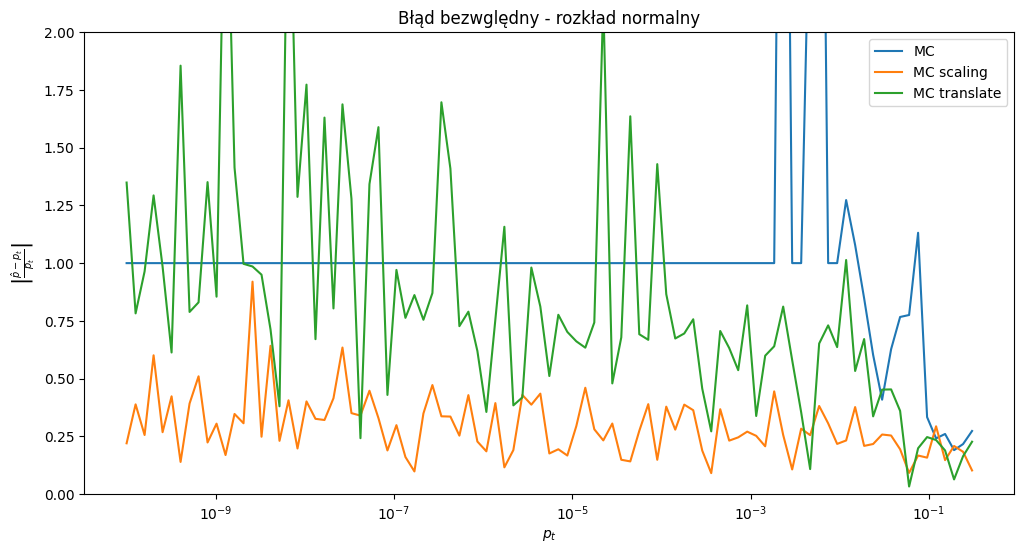

In [51]:
plt.figure(figsize=(12,6))
plt.plot(x_pt_list, np.array(MC_error), label='MC')
plt.plot(x_pt_list, np.array(MC_s_error), label='MC scaling')
plt.plot(x_pt_list, np.array(MC_t_error), label='MC translate')
plt.xlabel('$p_t$')
plt.ylabel('$\left|\\frac{\hat{p} - p_t}{p_t}\\right|$')
plt.title('Błąd bezwględny - rozkład normalny')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(0, 2)
# plt.xlim(10, 0)
plt.legend()
plt.savefig('blad_bezwzgledny_normalny', dpi=300)

In [600]:
print(monte_carlo_estimate(probe_MC, t))
print(monte_carlo_estimate(probe_IS_translation, t, lambda x: dist.pdf(x)/dist.pdf(x - c)))
print(monte_carlo_estimate(probe_IS_scalling, t, lambda x: a * dist.pdf(x)/dist.pdf(x/a)))

0.0
3.392779138526381e-10
6.683207810692441e-10


#### Testy dotyczące wzrostu efektywności

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\G'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_127335/3949802019.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_127335/3949802019.py:9: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


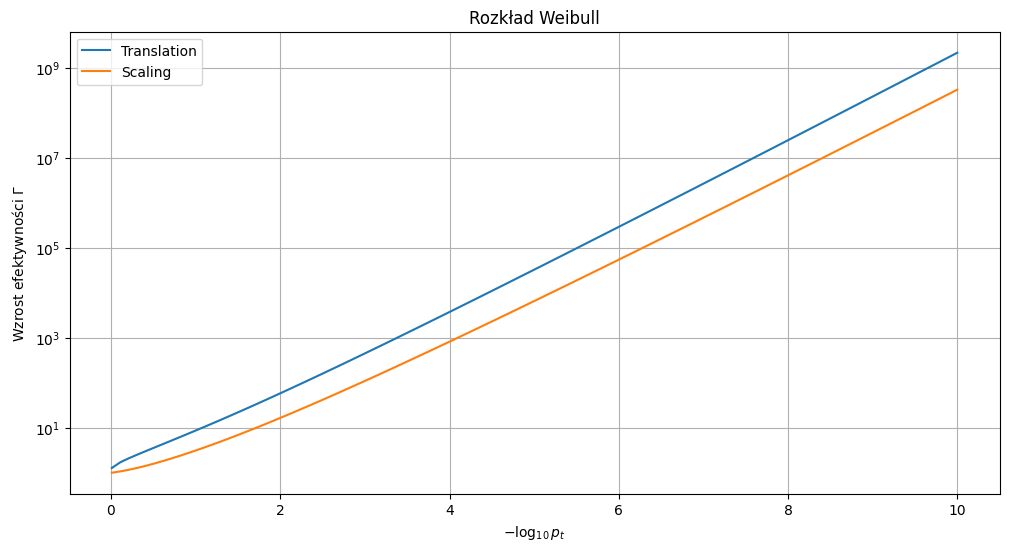

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(x_t, y_t, label='Translation')
plt.plot(x_s, y_s, label='Scaling')
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład Weibull')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.legend()
plt.savefig('wzrost_efektywnosci_weibull', dpi=300)
plt.show()